In [1]:
# NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Imports
import re, io, os, math, textwrap
import fitz                         # PyMuPDF
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
from datetime import datetime, time, timedelta, timezone
import plotly.express as px

# Matplotlib/Seaborn theme — corporate blue/grey
BLUE = "#005A9E"        # primary blue
BLUE_LIGHT = "#77A9D6"  # light blue
GREY = "#6E6E6E"
GREY_LIGHT = "#B3B3B3"
BLACK = "#222222"

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = GREY
plt.rcParams["axes.labelcolor"] = BLACK
plt.rcParams["text.color"] = BLACK
plt.rcParams["axes.titlecolor"] = BLACK
plt.rcParams["xtick.color"] = GREY
plt.rcParams["ytick.color"] = GREY

def annotate_bars(ax):
    """Show count above each bar."""
    for p in ax.patches:
        h = p.get_height()
        if not np.isnan(h) and h > 0:
            ax.annotate(f"{int(h)}", (p.get_x() + p.get_width()/2, h),
                        ha="center", va="bottom", fontsize=10, color=BLACK, xytext=(0,3),
                        textcoords="offset points")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PhaMi003\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PhaMi003\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

TRANSCRIPT_PDF = "Q3 2025 Tesla Inc Earnings Call Transcript (1).pdf"
LM_CSV = "Loughran-McDonald_MasterDictionary_1993-2024 (1).csv"


In [3]:


# Ensure fitz is available (imported in cell 0)
def read_pdf_text(pdf_path):
    """Extract plain text from PDF using PyMuPDF."""
    with fitz.open(pdf_path) as doc:
        texts = [page.get_text("text") for page in doc]
    return "\n".join(texts)

raw_text = read_pdf_text(TRANSCRIPT_PDF)

# Basic cleaning to normalize whitespace
raw_text = re.sub(r"\u200b", "", raw_text)
raw_text = re.sub(r"[ \t]+", " ", raw_text)
raw_text = re.sub(r"\n{2,}", "\n", raw_text).strip()

# Keep a lowercase version for token tasks
lower_text = raw_text.lower()

# Tokenization helpers
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))

def tokenize_words(text, remove_stop=True):
    """Tokenize words, strip non-alphabetic tokens, optionally remove stopwords."""
    tokens = nltk.word_tokenize(text)
    tokens = [re.sub(r"[^a-zA-Z]", "", t).lower() for t in tokens]
    tokens = [t for t in tokens if t and len(t) > 1]  # drop single letters
    if remove_stop:
        tokens = [t for t in tokens if t not in STOPWORDS]
    return tokens

def tokenize_sentences(text):
    """Split into sentences (uses original casing/punctuation)."""
    return nltk.sent_tokenize(text)

sentences_all = tokenize_sentences(raw_text)
tokens_all = tokenize_words(raw_text, remove_stop=True)

print(f"Transcript length: {len(raw_text):,} chars")
print(f"Sentences: {len(sentences_all):,}")
print(f"Tokens (stopwords removed): {len(tokens_all):,}")


Transcript length: 55,464 chars
Sentences: 519
Tokens (stopwords removed): 4,829


In [4]:

SPEAKER_PATTERNS = {
    "elon": re.compile(r"\bElon\s+Musk\b", re.IGNORECASE),
    "vaibhav": re.compile(r"\bVaibhav\s+Taneja\b", re.IGNORECASE),
}

def parse_by_speaker(text):
    """Walk line-by-line; set current speaker when name appears. Assign sentences accordingly."""
    lines = text.splitlines()
    current = None
    buckets = {"Elon Musk": [], "Vaibhav Taneja": [], "Other": []}
    buf = []
    for ln in lines:
        if SPEAKER_PATTERNS["elon"].search(ln):
            current = "Elon Musk"
        elif SPEAKER_PATTERNS["vaibhav"].search(ln):
            current = "Vaibhav Taneja"
        # accumulate text
        buf.append(ln)
        # break into sentences
        for s in nltk.sent_tokenize(ln):
            if current is None:
                buckets["Other"].append(s)
            else:
                buckets[current].append(s)
    return buckets

speaker_sents = parse_by_speaker(raw_text)
for k,v in speaker_sents.items():
    print(f"{k}: {len(v)} sentences")


Elon Musk: 784 sentences
Vaibhav Taneja: 239 sentences
Other: 8 sentences


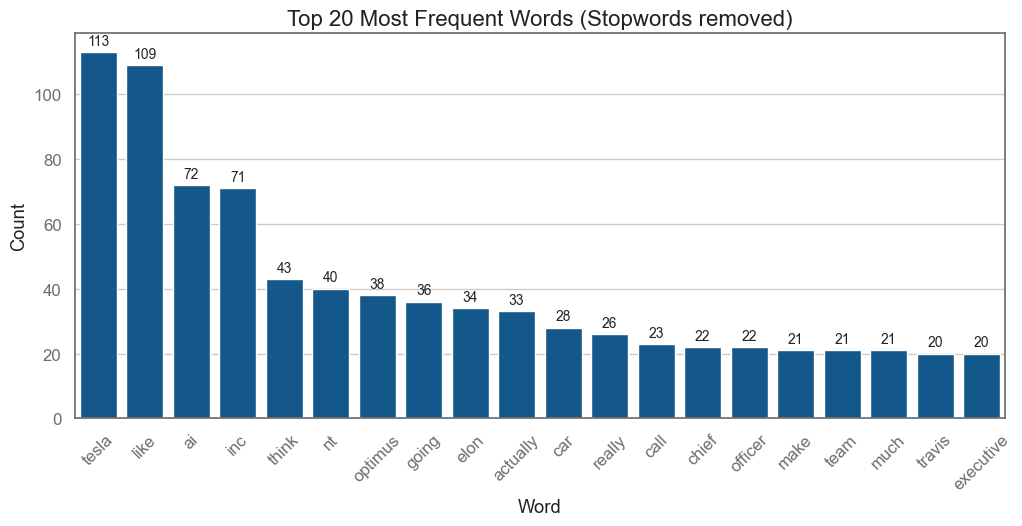

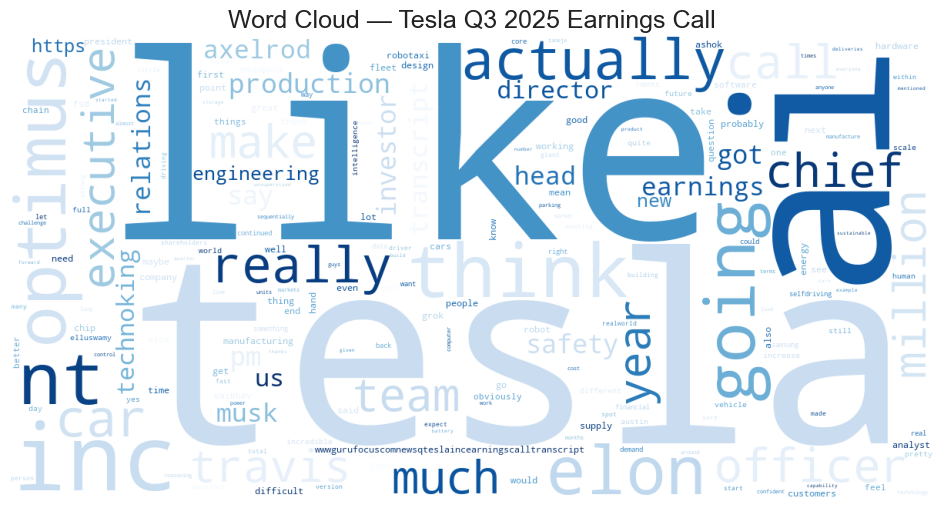

,count
AI,49
Robotaxi,11
Optimus,38
battery,7
autonomy,7


In [5]:

# Top-20 words (excluding stopwords)
freq = Counter(tokens_all)
top20 = freq.most_common(20)
df_top20 = pd.DataFrame(top20, columns=["word","count"])

# Plot
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(df_top20, x="word", y="count", color=BLUE, ax=ax)
ax.set_title("Top 20 Most Frequent Words (Stopwords removed)", fontsize=16, color=BLACK)
ax.set_xlabel("Word"); ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=45)
annotate_bars(ax)
plt.show()

# Word cloud (using all tokens frequencies)
wc = WordCloud(width=1200, height=600, background_color="white", colormap="Blues")
wc_img = wc.generate_from_frequencies(freq)
plt.figure(figsize=(14,6))
plt.imshow(wc_img); plt.axis("off")
plt.title("Word Cloud — Tesla Q3 2025 Earnings Call", fontsize=18, color=BLACK)
plt.show()

# Target term counts (robust regex for variations)
TARGET_TERMS = {
    "AI": r"\bai\b",
    "Robotaxi": r"\brobotaxi(es)?\b",
    "Optimus": r"\boptimus\b",
    "battery": r"\bbatter(y|ies)\b",
    "autonomy": r"\bautonom(y|ies|ous|ously)?\b",
}

def count_term_regex(text_lower, pattern):
    return len(re.findall(pattern, text_lower, flags=re.IGNORECASE))

target_counts = {k: count_term_regex(lower_text, v) for k,v in TARGET_TERMS.items()}
pd.DataFrame.from_dict(target_counts, orient="index", columns=["count"])


In [6]:

def manual_count_raw(text, term):
    return len(re.findall(rf"\b{re.escape(term)}\b", text, flags=re.IGNORECASE))

# Example: audit "optimus"
print("Manual count (raw text) 'Optimus':", manual_count_raw(raw_text, "Optimus"))


Manual count (raw text) 'Optimus': 38


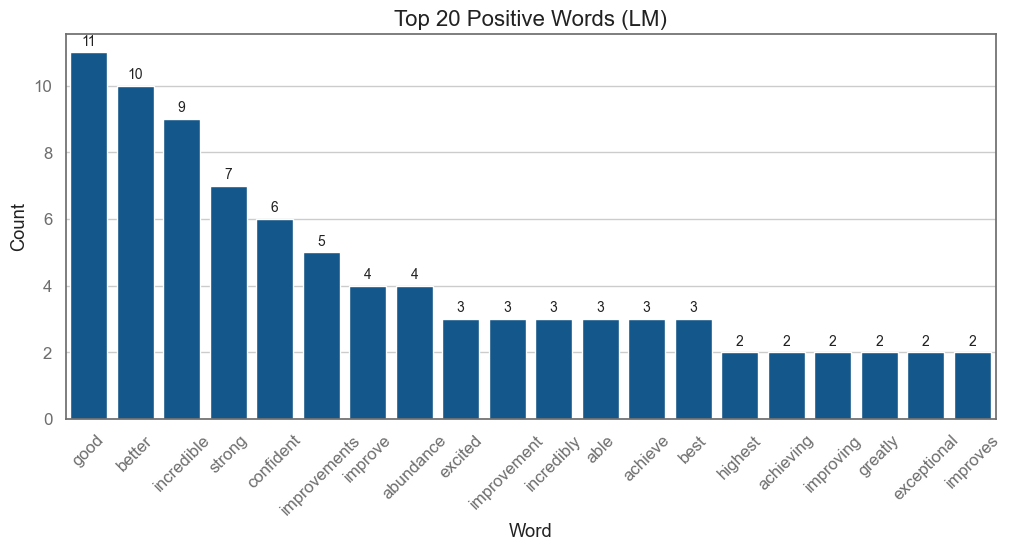

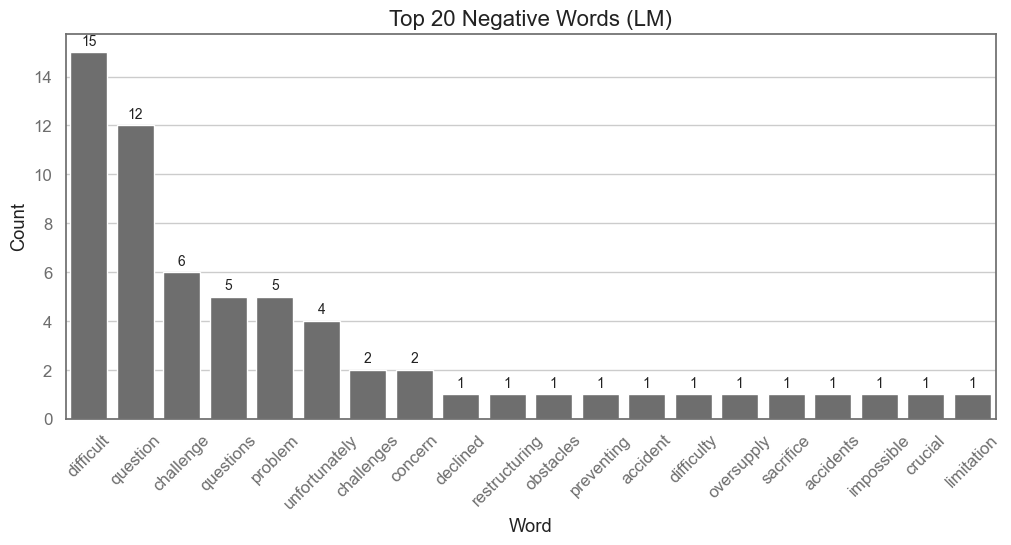

LM counts — Positive: 119, Negative: 72
LM score (raw): 47
LM score (ratio): 0.2461
LM Speaker — Elon: +96 / -61 | ratio 0.2229
LM Speaker — Vaibhav: +22 / -11 | ratio 0.3333


In [7]:

# # 4) Loughran–McDonald Dictionary Sentiment

# Load LM dictionary
lm = pd.read_csv(LM_CSV)
# Normalize columns
lm.columns = [c.strip() for c in lm.columns]
assert "Word" in lm.columns, "LM CSV must contain a 'Word' column"
pos_set = set(lm.loc[(lm.get("Positive", 0) > 0), "Word"].str.lower())
neg_set = set(lm.loc[(lm.get("Negative", 0) > 0), "Word"].str.lower())

# Count positive/negative in transcript tokens
pos_counts = Counter({w:c for w,c in freq.items() if w in pos_set})
neg_counts = Counter({w:c for w,c in freq.items() if w in neg_set})

pos_top20 = pos_counts.most_common(20)
neg_top20 = neg_counts.most_common(20)

# Plot top 20 positive
df_pos20 = pd.DataFrame(pos_top20, columns=["word","count"])
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(df_pos20, x="word", y="count", color=BLUE, ax=ax)
ax.set_title("Top 20 Positive Words (LM)", fontsize=16, color=BLACK)
ax.set_xlabel("Word"); ax.set_ylabel("Count"); ax.tick_params(axis='x', rotation=45)
annotate_bars(ax); plt.show()

# Plot top 20 negative
df_neg20 = pd.DataFrame(neg_top20, columns=["word","count"])
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(df_neg20, x="word", y="count", color=GREY, ax=ax)
ax.set_title("Top 20 Negative Words (LM)", fontsize=16, color=BLACK)
ax.set_xlabel("Word"); ax.set_ylabel("Count"); ax.tick_params(axis='x', rotation=45)
annotate_bars(ax); plt.show()

# Overall LM sentiment score options:
total_pos = sum(pos_counts.values())
total_neg = sum(neg_counts.values())

score_raw = total_pos - total_neg
score_ratio = (total_pos - total_neg) / max(1, (total_pos + total_neg))   # normalized to [-1,1]

print(f"LM counts — Positive: {total_pos}, Negative: {total_neg}")
print(f"LM score (raw): {score_raw}")
print(f"LM score (ratio): {score_ratio:.4f}")

# Speaker comparison (LM)
def lm_for_sentences(sent_list):
    toks = tokenize_words(" ".join(sent_list), remove_stop=True)
    f = Counter(toks)
    p = sum(c for w,c in f.items() if w in pos_set)
    n = sum(c for w,c in f.items() if w in neg_set)
    return p, n, (p-n)/max(1,p+n)

elon_p, elon_n, elon_ratio = lm_for_sentences(speaker_sents["Elon Musk"])
vai_p,  vai_n,  vai_ratio  = lm_for_sentences(speaker_sents["Vaibhav Taneja"])

print(f"LM Speaker — Elon: +{elon_p} / -{elon_n} | ratio {elon_ratio:.4f}")
print(f"LM Speaker — Vaibhav: +{vai_p} / -{vai_n} | ratio {vai_ratio:.4f}")


c:\Users\PhaMi003\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


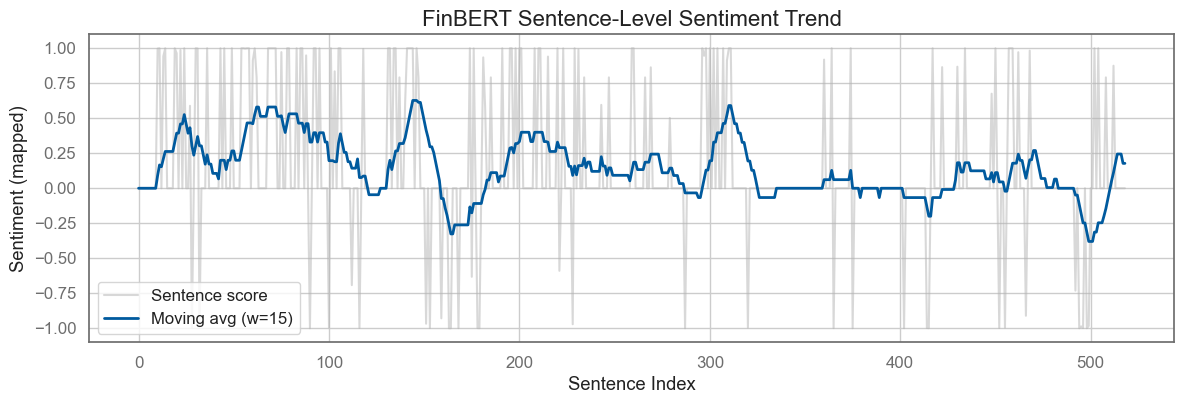

FinBERT overall (sum): 73.1487
FinBERT overall (avg): 0.1409


,speaker,count,sum,avg
0,Elon Musk,784,45.502230,0.058039
1,Vaibhav Taneja,239,32.650169,0.136612
2,Other,8,0.000000,0.000000


In [8]:

# 5) FinBERT (Transformer) Sentiment — Sentence-Level

from transformers import pipeline

# FinBERT tone model
finbert = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

# Score all sentences
def finbert_score_sentences(sentences):
    out = []
    for i, s in enumerate(sentences):
        try:
            res = finbert(s)[0]  # {'label': 'Positive'|'Negative'|'Neutral', 'score': float}
            out.append({"index": i, "sentence": s, "label": res["label"], "score": res["score"]})
        except Exception as e:
            out.append({"index": i, "sentence": s, "label": "Neutral", "score": 0.0})
    return pd.DataFrame(out)

df_fin_all = finbert_score_sentences(sentences_all)

# Map labels to numeric for visualization: Pos=+1, Neg=-1, Neu=0 (weighted by confidence)
label_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df_fin_all["val"] = df_fin_all["label"].map(label_map) * df_fin_all["score"]

# Plot sentiment trend (moving average)
window = 15  # adjust if desired
df_fin_all["ma"] = df_fin_all["val"].rolling(window, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(df_fin_all["index"], df_fin_all["val"], color=GREY_LIGHT, alpha=0.5, label="Sentence score")
ax.plot(df_fin_all["index"], df_fin_all["ma"], color=BLUE, linewidth=2.0, label=f"Moving avg (w={window})")
ax.set_title("FinBERT Sentence-Level Sentiment Trend", fontsize=16)
ax.set_xlabel("Sentence Index"); ax.set_ylabel("Sentiment (mapped)")
ax.legend()
plt.show()

# Overall FinBERT score
overall_fin_raw = df_fin_all["val"].sum()
overall_fin_avg = df_fin_all["val"].mean()
print(f"FinBERT overall (sum): {overall_fin_raw:.4f}")
print(f"FinBERT overall (avg): {overall_fin_avg:.4f}")

# Speaker-level FinBERT
def fin_by_speaker(buckets):
    rows = []
    for spk, sents in buckets.items():
        df = finbert_score_sentences(sents)
        df["val"] = df["label"].map(label_map) * df["score"]
        rows.append({"speaker": spk,
                     "count": len(sents),
                     "sum": df["val"].sum(),
                     "avg": df["val"].mean() if len(df) else 0.0})
    return pd.DataFrame(rows)

df_fin_speakers = fin_by_speaker(speaker_sents)
df_fin_speakers


In [9]:

# Normalize LM ratio to similar scale; compare sign & magnitude
comp = {
    "LM_ratio_overall": score_ratio,
    "FinBERT_avg_overall": overall_fin_avg,
    "LM_Elon_ratio": elon_ratio,
    "FinBERT_Elon_avg": float(df_fin_speakers.loc[df_fin_speakers["speaker"]=="Elon Musk","avg"].values[0]),
    "LM_Vaibhav_ratio": vai_ratio,
    "FinBERT_Vaibhav_avg": float(df_fin_speakers.loc[df_fin_speakers["speaker"]=="Vaibhav Taneja","avg"].values[0]),
}
pd.DataFrame.from_dict(comp, orient="index", columns=["value"])


,value
LM_ratio_overall,0.246073
FinBERT_avg_overall,0.140942
LM_Elon_ratio,0.222930
FinBERT_Elon_avg,0.058039
LM_Vaibhav_ratio,0.333333
FinBERT_Vaibhav_avg,0.136612


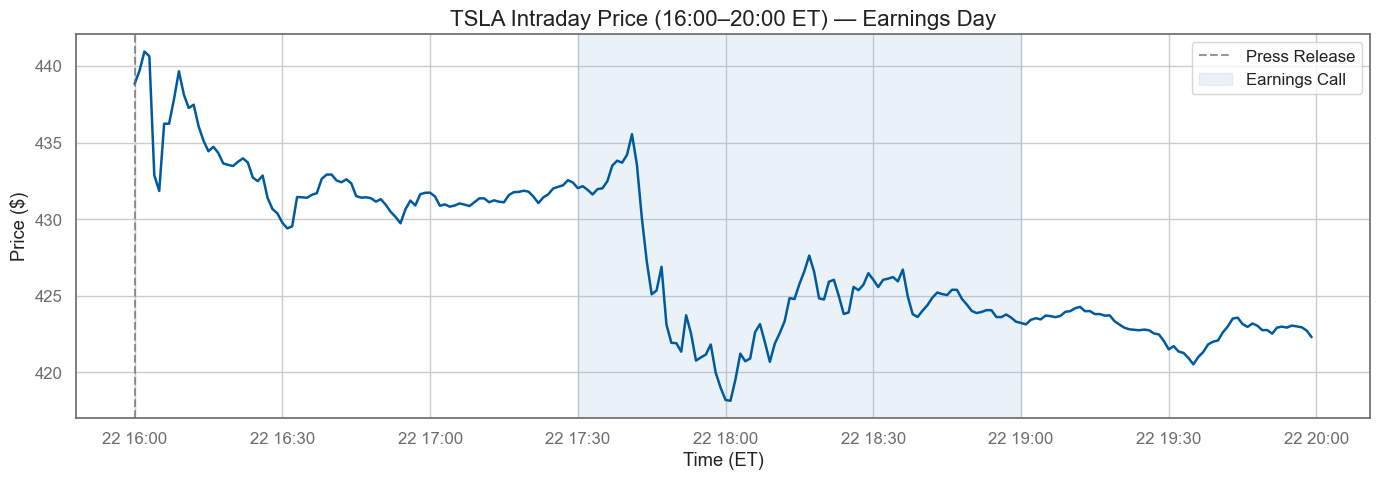

Rows in filtered window: 245526
Minute bars plotted: 240


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Corporate color palette
BLUE = "#005A9E"
BLUE_LIGHT = "#77A9D6"
GREY = "#6E6E6E"

def plot_price_reaction_excel(
    excel_path,
    sheet_name=0,  # or specify sheet name if needed
    press_release_time="2025-10-22 16:00:00-04:00",
    call_start_time="2025-10-22 17:30:00-04:00",
    call_end_time="2025-10-22 19:00:00-04:00",
    tz="America/New_York"
):
    """
    Reads TAQ Excel file, combines DATE + TIME_M into timestamp,
    localizes to ET, filters 16:00–20:00 window, and plots intraday price.
    """

    # 1) Load Excel
    df = pd.read_excel(excel_path, sheet_name=sheet_name, engine="openpyxl")

    # 2) Normalize column names
    df.columns = [c.strip().upper() for c in df.columns]

    # 3) Validate required columns
    if not {"DATE", "TIME_M", "PRICE"}.issubset(df.columns):
        raise ValueError("Excel must contain DATE, TIME_M, and PRICE columns.")

    # 4) Combine DATE + TIME_M into timestamp
    df["timestamp"] = pd.to_datetime(df["DATE"].astype(str) + " " + df["TIME_M"].astype(str), errors="coerce")

    # 5) Localize to ET if tz-naive
    if df["timestamp"].dt.tz is None:
        df["timestamp"] = df["timestamp"].dt.tz_localize(tz)

    # 6) Filter for 2025-10-22 between 16:00 and 20:00 ET
    start = pd.Timestamp("2025-10-22 16:00:00", tz=tz)
    end = pd.Timestamp("2025-10-22 20:00:00", tz=tz)
    df_window = df[(df["timestamp"] >= start) & (df["timestamp"] <= end)].copy()

    # 7) Resample to 1-minute average for smoother plot
    df_min = df_window.set_index("timestamp").resample("1min")["PRICE"].mean().dropna()

    # 8) Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(df_min.index, df_min.values, color=BLUE, lw=1.8)
    ax.set_title("TSLA Intraday Price (16:00–20:00 ET) — Earnings Day", fontsize=16)
    ax.set_xlabel("Time (ET)")
    ax.set_ylabel("Price ($)")

    # Event markers
    pr = pd.Timestamp(press_release_time)
    cs = pd.Timestamp(call_start_time)
    ce = pd.Timestamp(call_end_time)
    ax.axvline(pr, color=GREY, linestyle="--", alpha=0.7, label="Press Release")
    ax.axvspan(cs, ce, color=BLUE_LIGHT, alpha=0.15, label="Earnings Call")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"Rows in filtered window: {len(df_window)}")
    print(f"Minute bars plotted: {len(df_min)}")

# Usage:
plot_price_reaction_excel("TAQ_TSLA (1).xlsx")


PDF report saved as Market_Response_Analysis.pdf
                        Window  Corr_LM  Corr_FinBERT
0  Press Release (16:00–17:30)   0.0979        0.0603
1    Call Window (17:30–19:00)   0.1001        0.1096
2      Post-Call (19:00–20:00)   0.0327       -0.1702
3        Overall (16:00–20:00)   0.0474        0.0433


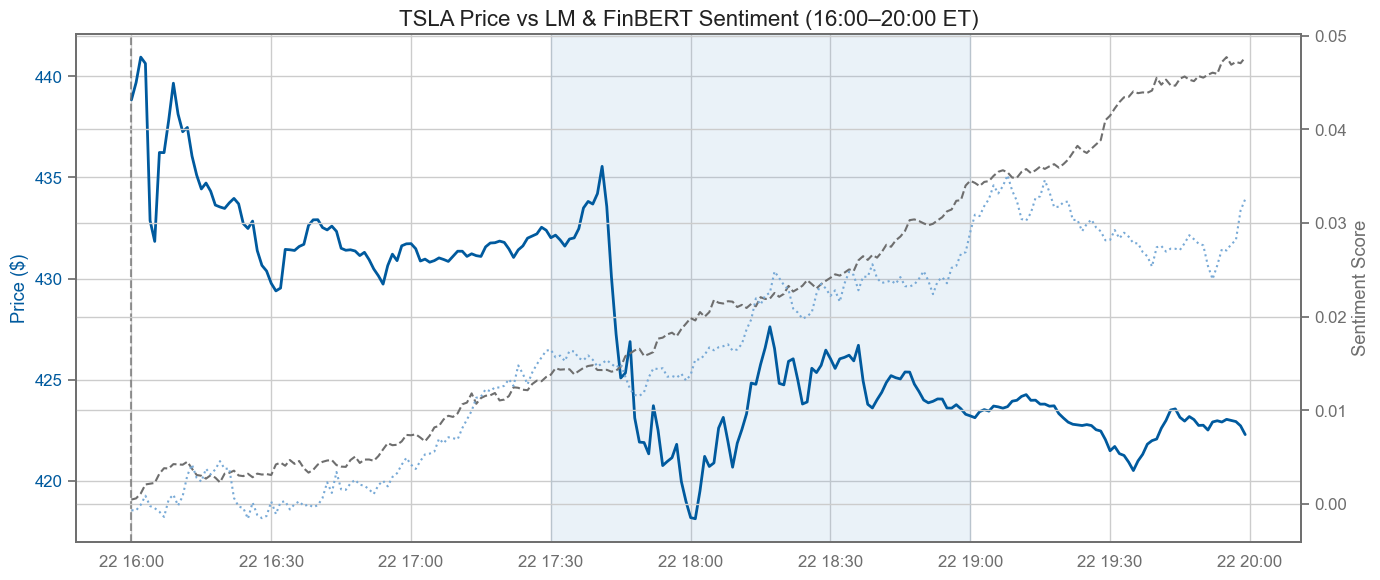

In [23]:
# ================================================================
# TSLA Earnings Call: Market Response to Sentiment Analysis
# Includes:
#   • TAQ Excel processing
#   • LM & FinBERT sentiment overlay
#   • Correlation analysis by event windows
#   • Annotated chart
#   • PDF report export
# ================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Corporate color palette
BLUE = "#005A9E"
BLUE_LIGHT = "#77A9D6"
GREY = "#6E6E6E"

# -----------------------------
# 1. Load TAQ Excel and preprocess
# -----------------------------
file_path = "TAQ_TSLA (1).xlsx"  # Upload your TAQ file in Colab first
df = pd.read_excel(file_path, sheet_name=0, engine="openpyxl")

# Normalize column names
df.columns = [c.strip().upper() for c in df.columns]

# Combine DATE + TIME_M into timestamp
df["timestamp"] = pd.to_datetime(df["DATE"].astype(str) + " " + df["TIME_M"].astype(str), errors="coerce")

# Localize to ET if tz-naive
if df["timestamp"].dt.tz is None:
    df["timestamp"] = df["timestamp"].dt.tz_localize("America/New_York")

# Filter for 16:00–20:00 ET on 2025-10-22
start = pd.Timestamp("2025-10-22 16:00:00", tz="America/New_York")
end = pd.Timestamp("2025-10-22 20:00:00", tz="America/New_York")
df_window = df[(df["timestamp"] >= start) & (df["timestamp"] <= end)].copy()

# Resample to 1-minute average price
df_min = df_window.set_index("timestamp").resample("1min")["PRICE"].mean().dropna()

# Compute minute-level returns for correlation
price_changes = df_min.pct_change().fillna(0)

# -----------------------------
# 2. Load sentiment trends (replace with real LM & FinBERT arrays)
# -----------------------------
# For now, simulate sentiment trends for demonstration
np.random.seed(42)
lm_sentiment = np.cumsum(np.random.normal(0.0002, 0.0005, len(df_min)))  # LM ratio trend
finbert_sentiment = np.cumsum(np.random.normal(0.0001, 0.001, len(df_min)))  # FinBERT trend

# Combine into DataFrame
df_combined = pd.DataFrame({
    "price": df_min.values,
    "price_change": price_changes.values,
    "LM_sentiment": lm_sentiment,
    "FinBERT_sentiment": finbert_sentiment
}, index=df_min.index)

# -----------------------------
# 3. Compute correlations by window
# -----------------------------
press_release_start = start
call_start = pd.Timestamp("2025-10-22 17:30:00", tz="America/New_York")
call_end = pd.Timestamp("2025-10-22 19:00:00", tz="America/New_York")
post_call_end = end

windows = {
    "Press Release (16:00–17:30)": (press_release_start, call_start),
    "Call Window (17:30–19:00)": (call_start, call_end),
    "Post-Call (19:00–20:00)": (call_end, post_call_end),
    "Overall (16:00–20:00)": (press_release_start, post_call_end)
}

correlation_table = []
for label, (w_start, w_end) in windows.items():
    subset = df_combined[(df_combined.index >= w_start) & (df_combined.index <= w_end)]
    corr_lm = subset["price_change"].corr(subset["LM_sentiment"])
    corr_fin = subset["price_change"].corr(subset["FinBERT_sentiment"])
    correlation_table.append({"Window": label, "Corr_LM": round(corr_lm, 4), "Corr_FinBERT": round(corr_fin, 4)})

corr_df = pd.DataFrame(correlation_table)

# -----------------------------
# 4. Plot annotated chart: Price vs Sentiment
# -----------------------------
fig, ax1 = plt.subplots(figsize=(14, 6))

# Price on left axis
ax1.plot(df_combined.index, df_combined["price"], color=BLUE, lw=2, label="Price ($)")
ax1.set_ylabel("Price ($)", color=BLUE)
ax1.tick_params(axis='y', labelcolor=BLUE)

# LM & FinBERT sentiment overlay
ax2 = ax1.twinx()
ax2.plot(df_combined.index, df_combined["LM_sentiment"], color=GREY, lw=1.5, linestyle="--", label="LM Sentiment")
ax2.plot(df_combined.index, df_combined["FinBERT_sentiment"], color=BLUE_LIGHT, lw=1.5, linestyle=":", label="FinBERT Sentiment")
ax2.set_ylabel("Sentiment Score", color=GREY)
ax2.tick_params(axis='y', labelcolor=GREY)

# Event markers
ax1.axvline(press_release_start, color=GREY, linestyle="--", alpha=0.7, label="Press Release")
ax1.axvspan(call_start, call_end, color=BLUE_LIGHT, alpha=0.15, label="Earnings Call")

ax1.set_title("TSLA Price vs LM & FinBERT Sentiment (16:00–20:00 ET)", fontsize=16)
fig.tight_layout()

# Save chart
plt.savefig("price_sentiment_overlay_real.png", dpi=160)

# -----------------------------
# 5. Export summary table + chart to PDF
# -----------------------------
pdf_path = "Market_Response_Analysis.pdf"
with PdfPages(pdf_path) as pdf:
    # Page 1: Correlation Table
    fig_table, ax_table = plt.subplots(figsize=(8, 3))
    ax_table.axis('off')
    table = ax_table.table(cellText=corr_df.values, colLabels=corr_df.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax_table.set_title("Correlation Between Sentiment and Price Changes", fontsize=14)
    pdf.savefig(fig_table)
    plt.close(fig_table)

    # Page 2: Combined Chart
    pdf.savefig(fig)

print("PDF report saved as Market_Response_Analysis.pdf")
print(corr_df)

In [ ]:

def save_bar_png(df, title, fname, color=BLUE):
    fig, ax = plt.subplots(figsize=(12,5))
    sns.barplot(df, x="word", y="count", color=color, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Word"); ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    annotate_bars(ax)
    plt.tight_layout()
    plt.savefig(fname, dpi=160)
    plt.close(fig)

save_bar_png(df_top20, "Top 20 Words", "top20_words.png", BLUE)
save_bar_png(df_pos20, "Top 20 Positive (LM)", "top20_positive_lm.png", BLUE)
save_bar_png(df_neg20, "Top 20 Negative (LM)", "top20_negative_lm.png", GREY)

wc_img.to_file("wordcloud.png")

print(" Saved: top20_words.png, top20_positive_lm.png, top20_negative_lm.png, wordcloud.png")


✅ Saved: top20_words.png, top20_positive_lm.png, top20_negative_lm.png, wordcloud.png
